# FGS1 signal EDA

## Notebooks set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import os
import random

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Internal imports
import configuration as config

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Single planet

In [2]:
planets = list(os.listdir(f'{config.RAW_DATA_DIRECTORY}/train'))
random_planet = planets[random.randint(0, len(planets)-1)]
fgs_file = f'{config.RAW_DATA_DIRECTORY}/train/{random_planet}/FGS1_signal_0.parquet'
print(f'Example FGS1 signal file path: {fgs_file}')

Example FGS1 signal file path: ./data/raw/train/3840929681/FGS1_signal_0.parquet


In [3]:
# Read the Parquet file into a PyArrow Table
signal = pd.read_parquet(fgs_file).to_numpy().reshape(135000, 32, 32)
print(f'Raw signal shape: {signal.shape}')
print(f'Raw frame shape: {signal[0].shape}')

Raw signal shape: (135000, 32, 32)
Raw frame shape: (32, 32)


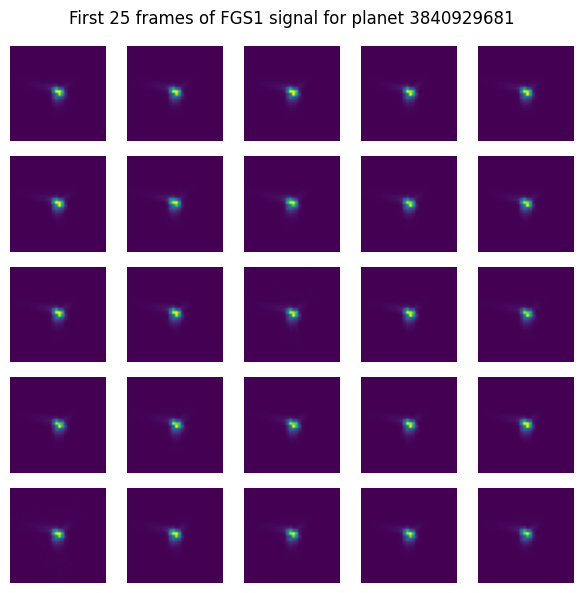

In [4]:
# Plot the first few frames
n_frames = 25
n_dim = int(n_frames**0.5)
dim = n_dim * 2
fig, axs = plt.subplots(n_dim, n_dim, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))
axs = axs.flatten()

fig.suptitle(f'First {n_frames} frames of FGS1 signal for planet {random_planet}')

for i in range(n_frames):
    frame = signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].imshow(frame)
    axs[i].axis('off')

fig.tight_layout()
fig.savefig('figures/EDA/01.4-FGS1_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

Yep - just what I thought. Narrow wavelength, but much smaller data & easy to crop even smaller. We can use the total brightness to see the transits. In fact, I bet they jump right out...

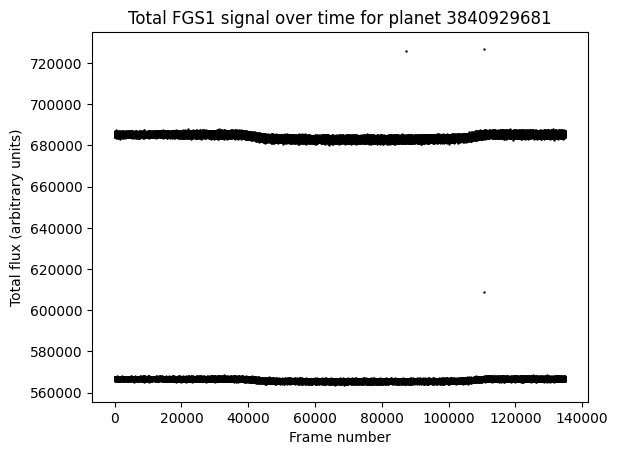

In [5]:
total_flux = [np.sum(frame) for frame in signal]

plt.title(f'Total FGS1 signal over time for planet {random_planet}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux (arbitrary units)')
plt.savefig('figures/EDA/01.4-example_raw_transit.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.show()

Bingo - definitely need some calibration, etc., but the transit is obvious. We can probably dump a lot of data too. I think the two traces are probably the alternating detector read thing mentioned in the section about the signal files on the [competition data page](https://www.kaggle.com/competitions/ariel-data-challenge-2025/data). We could probably just take the high signal trace. That by itself will cut the data in half. Then, since we are only interested in the spectrum of the planet we can take pieces of the time series. Maybe just the bottom of the well and one of the limbs. Use those parts of the time series for signal and background. Wow, this is a cool problem. One last thing before we call it a night - can we see the transit visually?

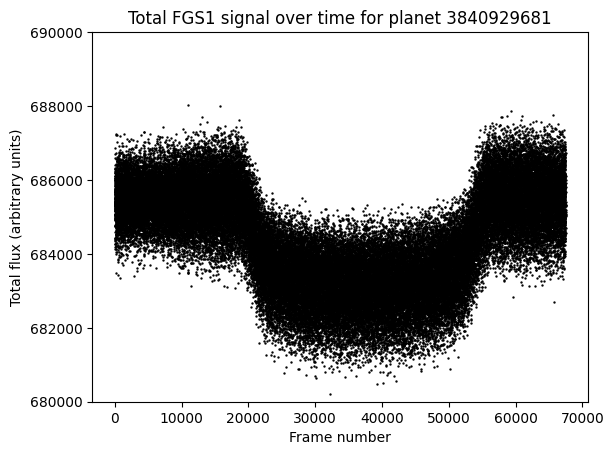

In [9]:
total_flux = [np.sum(frame) for frame in signal]
total_flux = total_flux[1:-1]
total_flux = total_flux[0::2]

plt.title(f'Total FGS1 signal over time for planet {random_planet}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux (arbitrary units)')
plt.ylim(680000, 690000)
plt.savefig('figures/EDA/01.4-transit_high_trace.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.show()

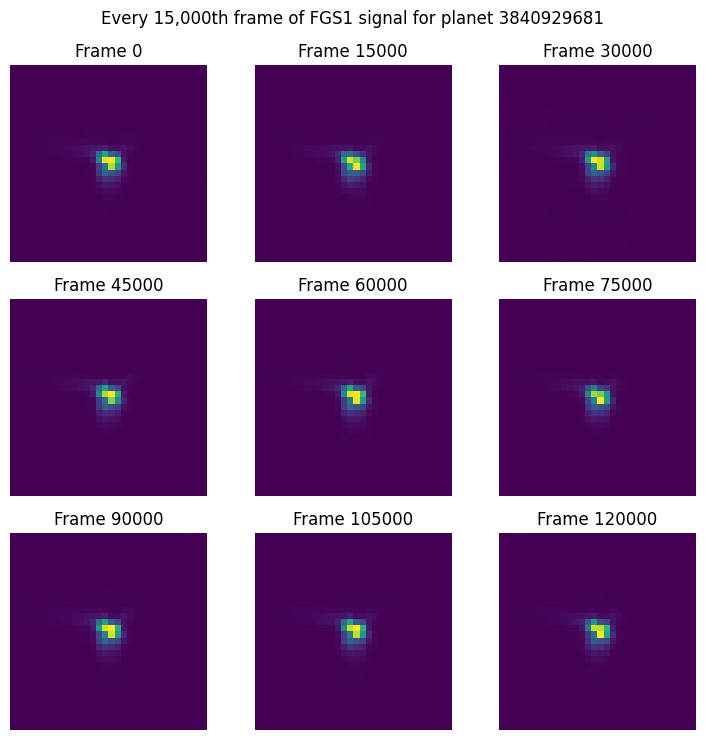

In [7]:
samples = signal[0::7000]

n_frames = 9
n_dim = int(n_frames**0.5)
dim = n_dim * 2.5
fig, axs = plt.subplots(n_dim, n_dim, figsize=(dim, dim))
axs = axs.flatten()

fig.suptitle(f'Every 15,000th frame of FGS1 signal for planet {random_planet}')

for i in list(range(n_frames)): 
    frame = samples[i]      
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].set_title(f'Frame {i*15000}')
    axs[i].imshow(frame)
    axs[i].axis('off')

fig.tight_layout()
fig.savefig('figures/EDA/01.4-example_transit_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

I think the next thing to focus on is figuring out how to/if we can align the FGS1 and AIRS signals in time. The timeseries have different numbers of frames, but I think there is probably going to be some metadata we can use in the ancillary data files. Tomorrow.